# Folded Peptides
This notebook loads in the data generated with AlphaFold2 and apply some machine learning ot it

# Preliminars

In [1]:
module("load", "cuda/11.2")
module("load", "tensorflow/gpu-cuda-11.2/2.4.0")

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import sklearn.model_selection
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [4]:
import wandb

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2021-11-24 10:20:54.699376: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


SystemError: GPU device not found

In [8]:
distance_list = pd.read_pickle('distance_list.pkl')
seq_list = pd.read_pickle('seq_dist_list.pkl')

## Labels

In [9]:
fig1 = pd.read_pickle('/u/jrlopez/Fig1_powerlaw.pkl')
fig1.loc[:,'Modified sequence'] = fig1['Modified sequence'].str.replace('_', '')
fig1_ch2 = fig1[fig1['Charge']==2]
fig1_ch2 = fig1_ch2.set_index('Modified sequence')

In [10]:
labels = fig1_ch2.loc[seq_list,:]['CCS'].values - fig1_ch2.loc[seq_list,:]['predicted_ccs'].values

# Padding

In [11]:
def pad(a):
    """Return bottom right padding."""
    zeros = np.zeros((33,33))
    zeros[:a.shape[0], :a.shape[1]] = a
    return zeros

In [12]:
padded_images = np.array([pad(a) for a in distance_list])

In [14]:
images_tf = tf.stack(padded_images)

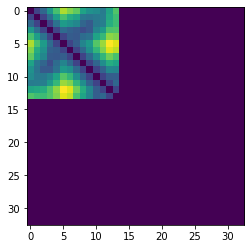

In [15]:
plt.imshow(padded_images[5])

# Train/val set split

In [16]:
x_train, x_val, y_train, y_val = sk.model_selection.train_test_split(padded_images, labels, test_size = 0.1, random_state = 23112021)

In [17]:
x_train = x_train[:,:,:,np.newaxis]
x_val = x_val[:,:,:,np.newaxis]

# Architecture

In [18]:
#Importing library
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

In [19]:
np.random.seed(1000)

#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(33,33,1), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(32,32,1,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(1))


#Model Summary
AlexNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 9, 9, 96)          11712     
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 96)          384       
_________________________________________________________________
activation (Activation)      (None, 9, 9, 96)          0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 96)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 256)         614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 256)         1024      
_________________________________________________________________
activation_1 (Activation)    (None, 5, 5, 256)         0

# Callbacks

In [20]:
import wandb

In [21]:
wandb.init(project="prot_alphafold2", entity="jlrestrepol")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jlrestrepol (use `wandb login --relogin` to force relogin)
2021-11-23 16:46:55.252377: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Trainig

In [22]:
from wandb.keras import WandbCallback

In [23]:
AlexNet.compile(loss = "mean_squared_error", optimizer= 'adam')

In [25]:
AlexNet.fit(x_train, y_train, epochs = 60, validation_data = (x_val, y_val), callbacks = [WandbCallback()])

2021-11-23 16:47:18.917368: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-23 16:47:18.948457: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz


Epoch 1/60


2021-11-23 16:47:20.152400: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-11-23 16:47:20.895546: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-11-23 16:47:20.902309: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


  9/351 [..............................] - ETA: 4s - loss: 139.5633  

2021-11-23 16:47:23.228514: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


351/351 [==============================] - 11s 20ms/step - loss: 133.3084 - val_loss: 211.9240
Epoch 2/60
351/351 [==============================] - 5s 13ms/step - loss: 126.8657 - val_loss: 134.4669
Epoch 3/60
351/351 [==============================] - 5s 14ms/step - loss: 132.0922 - val_loss: 133.6505
Epoch 4/60
351/351 [==============================] - 5s 14ms/step - loss: 128.4722 - val_loss: 128.7783
Epoch 5/60
351/351 [==============================] - 5s 13ms/step - loss: 128.1025 - val_loss: 139.3683
Epoch 6/60
351/351 [==============================] - 5s 14ms/step - loss: 129.4606 - val_loss: 135.8420
Epoch 7/60
351/351 [==============================] - 5s 13ms/step - loss: 125.8898 - val_loss: 129.5574
Epoch 8/60
351/351 [==============================] - 5s 14ms/step - loss: 126.6214 - val_loss: 130.9255
Epoch 9/60
351/351 [==============================] - 5s 14ms/step - loss: 123.6615 - val_loss: 142.3042
Epoch 10/60
351/351 [==============================] - 5s 14ms/st

KeyboardInterrupt: 

In [34]:
y_train

array([450.67263424, 517.52300744, 455.28498778, ..., 320.82473499,
       357.1339373 , 366.01892349])

In [33]:
x_val.shape

(1246, 33, 33, 1)